# Assigmnet 1

<hr>

In this assignment , construct the [GoogleNet](https://arxiv.org/abs/1409.4842)/Inception architecture reconstructed from scratch for fit outdata as outlined. This entails creating a neural network model that proved successful in the ILSVRC 2014 competition. The objective is to train this model on the FashionMNIST dataset, a collection of grayscale images depicting fashion items, encompassing various categories like shoes and clothing.

To ensure optimal model training, it is imperative to implement data normalization. This involves adjusting the pixel values of the images to a standardized range, promoting convergence during training. Additionally, PyTorch data loader implementation is necessary for efficient handling of the dataset, enabling seamless batch processing.

During the training phase, employ the Adam optimizer, a widely used optimization algorithm, with a learning rate set at 0.01. Training should span minimum of 50 epochs, each epoch representing a full iteration through the dataset. This extended training duration aims to enhance the ability of the model to discern patterns and features within the FashionMNIST dataset.

To evaluate the performance of the model, plot both the training and test error loss. These plots serve as visual indicators of the learning progress and generalization capabilities of the model.  Analyzing these curves can offer insights into potential adjustments or improvements needed in the model architecture or training parameters.

Lastly, for  ease of access, save the completed notebook to your Google Drive. Once the assignment is finished, share the notebook with mesfin.diro@aau.edu.et via Colab.

<hr>

20%


## Tip: Use GPU Acceleration

To running this notebook in Google Colab with GPU, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

Let's make sure that we have access to GPU. We can use nvidia-smi command to do that. In case of any problems navigate to Edit -> Notebook settings -> Hardware accelerator, set it to GPU, and then click Save.

In [ ]:
!nvidia-smi

Wed Nov 29 09:27:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Explore the current directory on your colab

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%cd {HOME}

/content


In [ ]:
#!pip install package
import os
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
from torchvision.models import Inception3
import torch.nn.functional as F
sns.reset_orig()


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),
                          (0.5))])

In [ ]:
trainset = FashionMNIST(root='./fm_data', train=True,
                                        download=True, transform=transform)

testset = FashionMNIST(root='./fm_data', train=False,
                                       download=True, transform=transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=140,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=140,
                                         shuffle=False, num_workers=2)

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./fm_data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./pretrained_model_II"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:

# Define InceptionNet model
class InceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionNet, self).__init__()
        # Load the pre-trained Inception v3 model without the auxiliary logits
        self.inception = Inception3(num_classes=num_classes, aux_logits=False)
        # Modify the first convolution layer to accept 1 channel instead of 3 ( for channel 1 image)
        self.inception.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, bias=False)

    def forward(self, x):
        # Transform the input to meet Inception v3 requirements
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        # Forward pass through Inception v3
        return self.inception(x)

#Initialize the InceptionNet model
model = InceptionNet(num_classes=10)
model = model.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the number of training epochs
num_epochs = 20

Epoch [1/20], Loss: 0.9724, Accuracy: 0.6855
Epoch [2/20], Loss: 0.4239, Accuracy: 0.8466
Epoch [3/20], Loss: 0.3208, Accuracy: 0.8865
Epoch [4/20], Loss: 0.2941, Accuracy: 0.8946
Epoch [5/20], Loss: 0.2618, Accuracy: 0.9057
Epoch [6/20], Loss: 0.2484, Accuracy: 0.9097
Epoch [7/20], Loss: 0.2361, Accuracy: 0.9149
Epoch [8/20], Loss: 0.2585, Accuracy: 0.9080
Epoch [9/20], Loss: 0.2602, Accuracy: 0.9050
Epoch [10/20], Loss: 0.2232, Accuracy: 0.9189
Epoch [11/20], Loss: 0.2060, Accuracy: 0.9259
Epoch [12/20], Loss: 0.1934, Accuracy: 0.9296
Epoch [13/20], Loss: 0.1781, Accuracy: 0.9349
Epoch [14/20], Loss: 0.1967, Accuracy: 0.9292
Epoch [15/20], Loss: 0.1745, Accuracy: 0.9357
Epoch [16/20], Loss: 0.1563, Accuracy: 0.9427
Epoch [17/20], Loss: 0.1489, Accuracy: 0.9453
Epoch [18/20], Loss: 0.1391, Accuracy: 0.9494
Epoch [19/20], Loss: 0.2725, Accuracy: 0.9051
Epoch [20/20], Loss: 0.1836, Accuracy: 0.9323


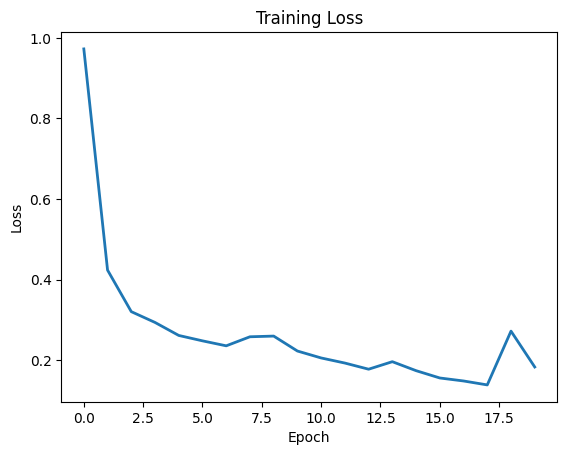

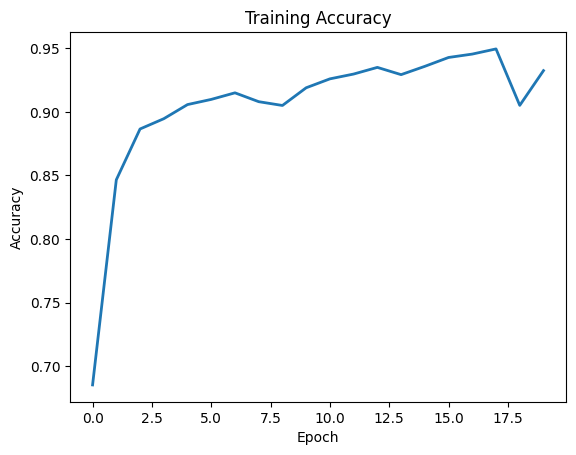

In [ ]:
# Initialize lists to store loss and accuracy values
train_loss = []
train_accuracy = []
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct / total

    # Append loss and accuracy values to the lists
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    # Print the current loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot the training loss
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Plot the training accuracy
plt.plot(train_accuracy)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * total_correct / total_samples
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 91.41%


In [ ]:
torch.save(model, CHECKPOINT_PATH)